In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation

from yellowbrick.cluster import KElbowVisualizer


sys.path.append('../src')
from clean_df import *
from sort_lyrics_to_genre import *
from countvec_cap2 import *

pd.options.display.max_rows = 200

In [2]:
ly = pd.read_csv('../data/1950_2019_with lyrics.csv')
ly.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
len(ly)

28372

In [4]:
ly.columns

Index(['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'len',
       'dating', 'violence', 'world/life', 'night/time', 'shake the audience',
       'family/gospel', 'romantic', 'communication', 'obscene', 'music',
       'movement/places', 'light/visual perceptions', 'family/spiritual',
       'like/girls', 'sadness', 'feelings', 'danceability', 'loudness',
       'acousticness', 'instrumentalness', 'valence', 'energy', 'topic',
       'age'],
      dtype='object')

In [5]:
ly.loc[ly['release_date']>1999]

,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,night/time,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
4751,3 doors down,duck and run,2000,pop,world unimportant free country tell cost live ...,71,0.000877,0.000877,0.407802,0.000877,...,0.284506,0.000877,0.500704,0.773069,0.014959,0.000072,0.849547,0.919917,world/life,0.285714
4752,ricky nelson,hello mary lou,2000,pop,hello goodbye heart sweet know hello goodbye h...,58,0.000923,0.000923,0.000923,0.000923,...,0.140091,0.000923,0.570021,0.631387,0.372489,0.000001,0.925804,0.601589,romantic,0.285714
4753,modest mouse,perfect disguise,2000,pop,perfect disguise look okay best worst cause co...,32,0.002105,0.175750,0.002105,0.002105,...,0.140042,0.070702,0.493122,0.653565,0.732931,0.209514,0.120981,0.359339,obscene,0.285714
4754,joe,i believe in you,2000,pop,believe dream believe like arrow heart believe...,55,0.001224,0.001224,0.725084,0.001224,...,0.058538,0.001224,0.457381,0.760634,0.176706,0.000000,0.198269,0.525511,world/life,0.285714
4755,fuel,empty spaces,2000,pop,mister maybe lend hand help drown starve soull...,49,0.001504,0.384026,0.001504,0.001504,...,0.313281,0.001504,0.469295,0.814630,0.000062,0.053644,0.343570,0.943942,violence,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28367,mack 10,10 million ways,2019,hip hop,cause fuck leave scar tick tock clock come kno...,78,0.001350,0.001350,0.001350,0.001350,...,0.065664,0.001350,0.889527,0.759711,0.062549,0.000000,0.751649,0.695686,obscene,0.014286
28368,m.o.p.,ante up (robbin hoodz theory),2019,hip hop,minks things chain ring braclets yap fame come...,67,0.001284,0.001284,0.035338,0.001284,...,0.001284,0.001284,0.662082,0.789580,0.004607,0.000002,0.922712,0.797791,obscene,0.014286
28369,nine,whutcha want?,2019,hip hop,get ban get ban stick crack relax plan attack ...,77,0.001504,0.154302,0.168988,0.001504,...,0.001504,0.001504,0.663165,0.726970,0.104417,0.000001,0.838211,0.767761,obscene,0.014286
28370,will smith,switch,2019,hip hop,check check yeah yeah hear thing call switch g...,67,0.001196,0.001196,0.001196,0.001196,...,0.001196,0.001196,0.883028,0.786888,0.007027,0.000503,0.508450,0.885882,obscene,0.014286


In [6]:
#subsets per genre
hiphop = sort_by_genre(ly, 'hip hop')
rock = sort_by_genre(ly, 'rock')
country = sort_by_genre(ly, 'country')
blues = sort_by_genre(ly, 'blues')
jazz = sort_by_genre(ly, 'jazz')
reggae = sort_by_genre(ly, 'reggae')
pop = sort_by_genre(ly, 'pop')


#all words per genre
hiphopwords= " ".join(hiphop['lyrics'])
rockwords= " ".join(rock['lyrics'])
blueswords= " ".join(blues['lyrics'])
countrywords= " ".join(country['lyrics'])
reggaewords= " ".join(reggae['lyrics'])
popwords= " ".join(pop['lyrics'])
jazzwords= " ".join(jazz['lyrics'])

In [7]:
genre_lyrics = pd.concat([ly['genre'], ly['lyrics']], axis=1)
genre_lyrics.head()

,genre,lyrics
0,pop,hold time feel break feel untrue convince spea...
1,pop,believe drop rain fall grow believe darkest ni...
2,pop,sweetheart send letter goodbye secret feel bet...
3,pop,kiss lips want stroll charm mambo chacha merin...
4,pop,till darling till matter know till dream live ...


In [8]:
#Panda dataset Genre: all words in all lyrics
rock_lyrics = lyrics_to_genre(sort_by_genre(ly, 'rock'), 'rock')
hiphop_lyrics = lyrics_to_genre(sort_by_genre(ly, 'hip hop'), 'hip hop')
pop_lyrics = lyrics_to_genre(sort_by_genre(ly, 'pop'), 'pop')
reggae_lyrics = lyrics_to_genre(sort_by_genre(ly, 'reggae'), 'reggae')
jazz_lyrics = lyrics_to_genre(sort_by_genre(ly, 'jazz'), 'jazz')
country_lyrics = lyrics_to_genre(sort_by_genre(ly, 'country'), 'country')
blues_lyrics = lyrics_to_genre(sort_by_genre(ly, 'blues'), 'blues')

In [9]:
my_stop_words = frozenset({'a','about','above','across','after','afterwards','again','against','all',
           'almost','alone','along','already','also','although','always','am','among','amongst','amoungst',
           'amount','an','and','another','any','anyhow','anyone','anything','anyway','anywhere','are','around',
           'as',
           'at',
           'baby',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides',
           'between',
           'beyond',
           'bill',
           'both',
           'bottom',
           'but',
           'by',
           'call',
           'can',
           'cannot',
           'cant',
           'cause',
           'co',
           'come',
           'con',
           'could',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'do',
           'done',
           'down',
           'due',
           'during',
           'each',
           'eg',
           'eight',
           'either',
           'eleven',
           'else',
           'elsewhere',
           'empty',
           'enough',
           'etc',
           'even',
           'ever',
           'every',
           'everyone',
           'everything',
           'everywhere',
           'except',
           'few',
           'fifteen',
           'fifty',
           'fill',
           'find',
           'fire',
           'first',
           'five',
           'for',
           'former',
           'formerly',
           'forty',
           'found',
           'four',
           'from',
           'front',
           'full',
           'further',
           'get',
           'give',
           'go',
           'gonna',
           'had',
           'has',
           'hasnt',
           'have',
           'he',
           'hence',
           'her',
           'here',
           'hereafter',
           'hereby',
           'herein',
           'hereupon',
           'hers',
           'herself',
           'him',
           'himself',
           'his',
           'hold',
           'how',
           'however',
           'hundred',
           'i',
           'ie',
           'if',
           'in',
           'inc',
           'indeed',
           'interest',
           'into',
           'is',
           'it',
           'its',
           'itself',
           'keep',
           'know',
           'last',
           'latter',
           'latterly',
           'least',
           'less',
           'like',
           'ltd',
           'made',
           'many',
           'may',
           'me',
           'meanwhile',
           'might',
           'mill',
           'mine',
           'more',
           'moreover',
           'most',
           'mostly',
           'move',
           'much',
           'must',
           'my',
           'myself',
           'name',
           'namely',
           'neither',
           'never',
           'nevertheless',
           'next',
           'nigga',
           'niggas',
           'niggaz',
           'nine',
           'no',
           'nobody',
           'none',
           'noone',
           'nor',
           'not',
           'nothing',
           'now',
           'nowhere',
           'of',
           'off',
           'often',
           'on',
           'once',
           'one',
           'only',
           'onto',
           'or',
           'other',
           'others',
           'otherwise',
           'our',
           'ours',
           'ourselves',
           'out',
           'over',
           'own',
           'part',
           'per',
           'perhaps',
           'please',
           'put',
           'rather',
           're',
           'right',
           'same',
           'say',
           'see',
           'seem',
           'seemed',
           'seeming',
           'seems',
           'serious',
           'several',
           'she',
           'should',
           'show',
           'side',
           'since',
           'sincere',
           'six',
           'sixty',
           'so',
           'some',
           'somehow',
           'someone',
           'something',
           'sometime',
           'sometimes',
           'somewhere',
           'still',
           'such',
           'system',
           'take',
           'ten',
           'than',
           'that',
           'the',
           'their',
           'them',
           'themselves',
           'then',
           'thence',
           'there',
           'thereafter',
           'thereby',
           'therefore',
           'therein',
           'thereupon',
           'these',
           'they',
           'thick',
           'thin',
           'thing',
           'third',
           'this',
           'those',
           'though',
           'three',
           'through',
           'throughout',
           'thru',
           'thus',
           'time',
           'to',
           'together',
           'too',
           'top',
           'toward',
           'towards',
           'twelve',
           'twenty',
           'two',
           'un',
           'under',
           'until',
           'up',
           'upon',
           'us',
           'very',
           'via',
           'was',
           'we',
           'well',
           'were',
           'what',
           'whatever',
           'when',
           'whence',
           'whenever',
           'where',
           'whereafter',
           'whereas',
           'whereby',
           'wherein',
           'whereupon',
           'wherever',
           'whether',
           'which',
           'while',
           'whither',
           'who',
           'whoever',
           'whole',
           'whom',
           'whose',
           'why',
           'will',
           'with',
           'within',
           'without',
           'would',
           'yeah',
           'year',
           'yet',
           'you',
           'your',
           'yours',
           'yourself',
           'yourselves'})

In [10]:
tfidf_vec = TfidfVectorizer(stop_words=my_stop_words)
count_vec = CountVectorizer(stop_words=my_stop_words)

In [11]:
# from sklearn.cluster import KMeans

# n_clusters = 12
# X2 = vectorizer(ly, count_vec)
# X = vectorizer(ly, tfidf_vec)
# kmeans = KMeans(n_clusters=n_clusters, random_state=0)
# prediction = kmeans.fit_predict(X)

## Tuning Models

## LDA

In [12]:
# # LDA

# # LDA can only uses raw term counts
# tf_feature_names = count_vec.get_feature_names() #theses are the words in our bag of words

# lda = LatentDirichletAllocation(n_components=5, learning_method='online',random_state=0, learning_decay=0.5)
# lda.fit(X2)
# lda.perplexity(X2)

In [13]:
# lda1 = LatentDirichletAllocation(n_components=5, learning_method='online',random_state=0, learning_decay=1.0)
# lda1.fit(X2)
# lda1.perplexity(X2)

In [14]:
# lda3 = LatentDirichletAllocation(n_components=5, learning_method='online',random_state=0)
# lda3.fit(X2)
# lda3.perplexity(X2)

In [15]:
# lda3 = LatentDirichletAllocation(n_components=10, learning_method='online',random_state=0)
# lda3.fit(X2)
# lda3.score(X2)

In [16]:
# lda4 = LatentDirichletAllocation(n_components=12, learning_method='online',random_state=0)
# lda4.fit(X2)
# lda4.score(X2)

In [17]:
# lda5 = LatentDirichletAllocation(n_components=15, learning_method='online',random_state=0)
# lda5.fit(X2)
# lda5.score(X2)

In [18]:
# lda6 = LatentDirichletAllocation(n_components=5, learning_method='online',random_state=0)
# lda6.fit(X2)
# lda6_score = lda6.score(X2)
# lda6_score

In [19]:
# lda7 = LatentDirichletAllocation(n_components=4, learning_method='online',random_state=0)
# lda7.fit(X2)
# lda7_score = lda7.score(X2)
# lda7_score

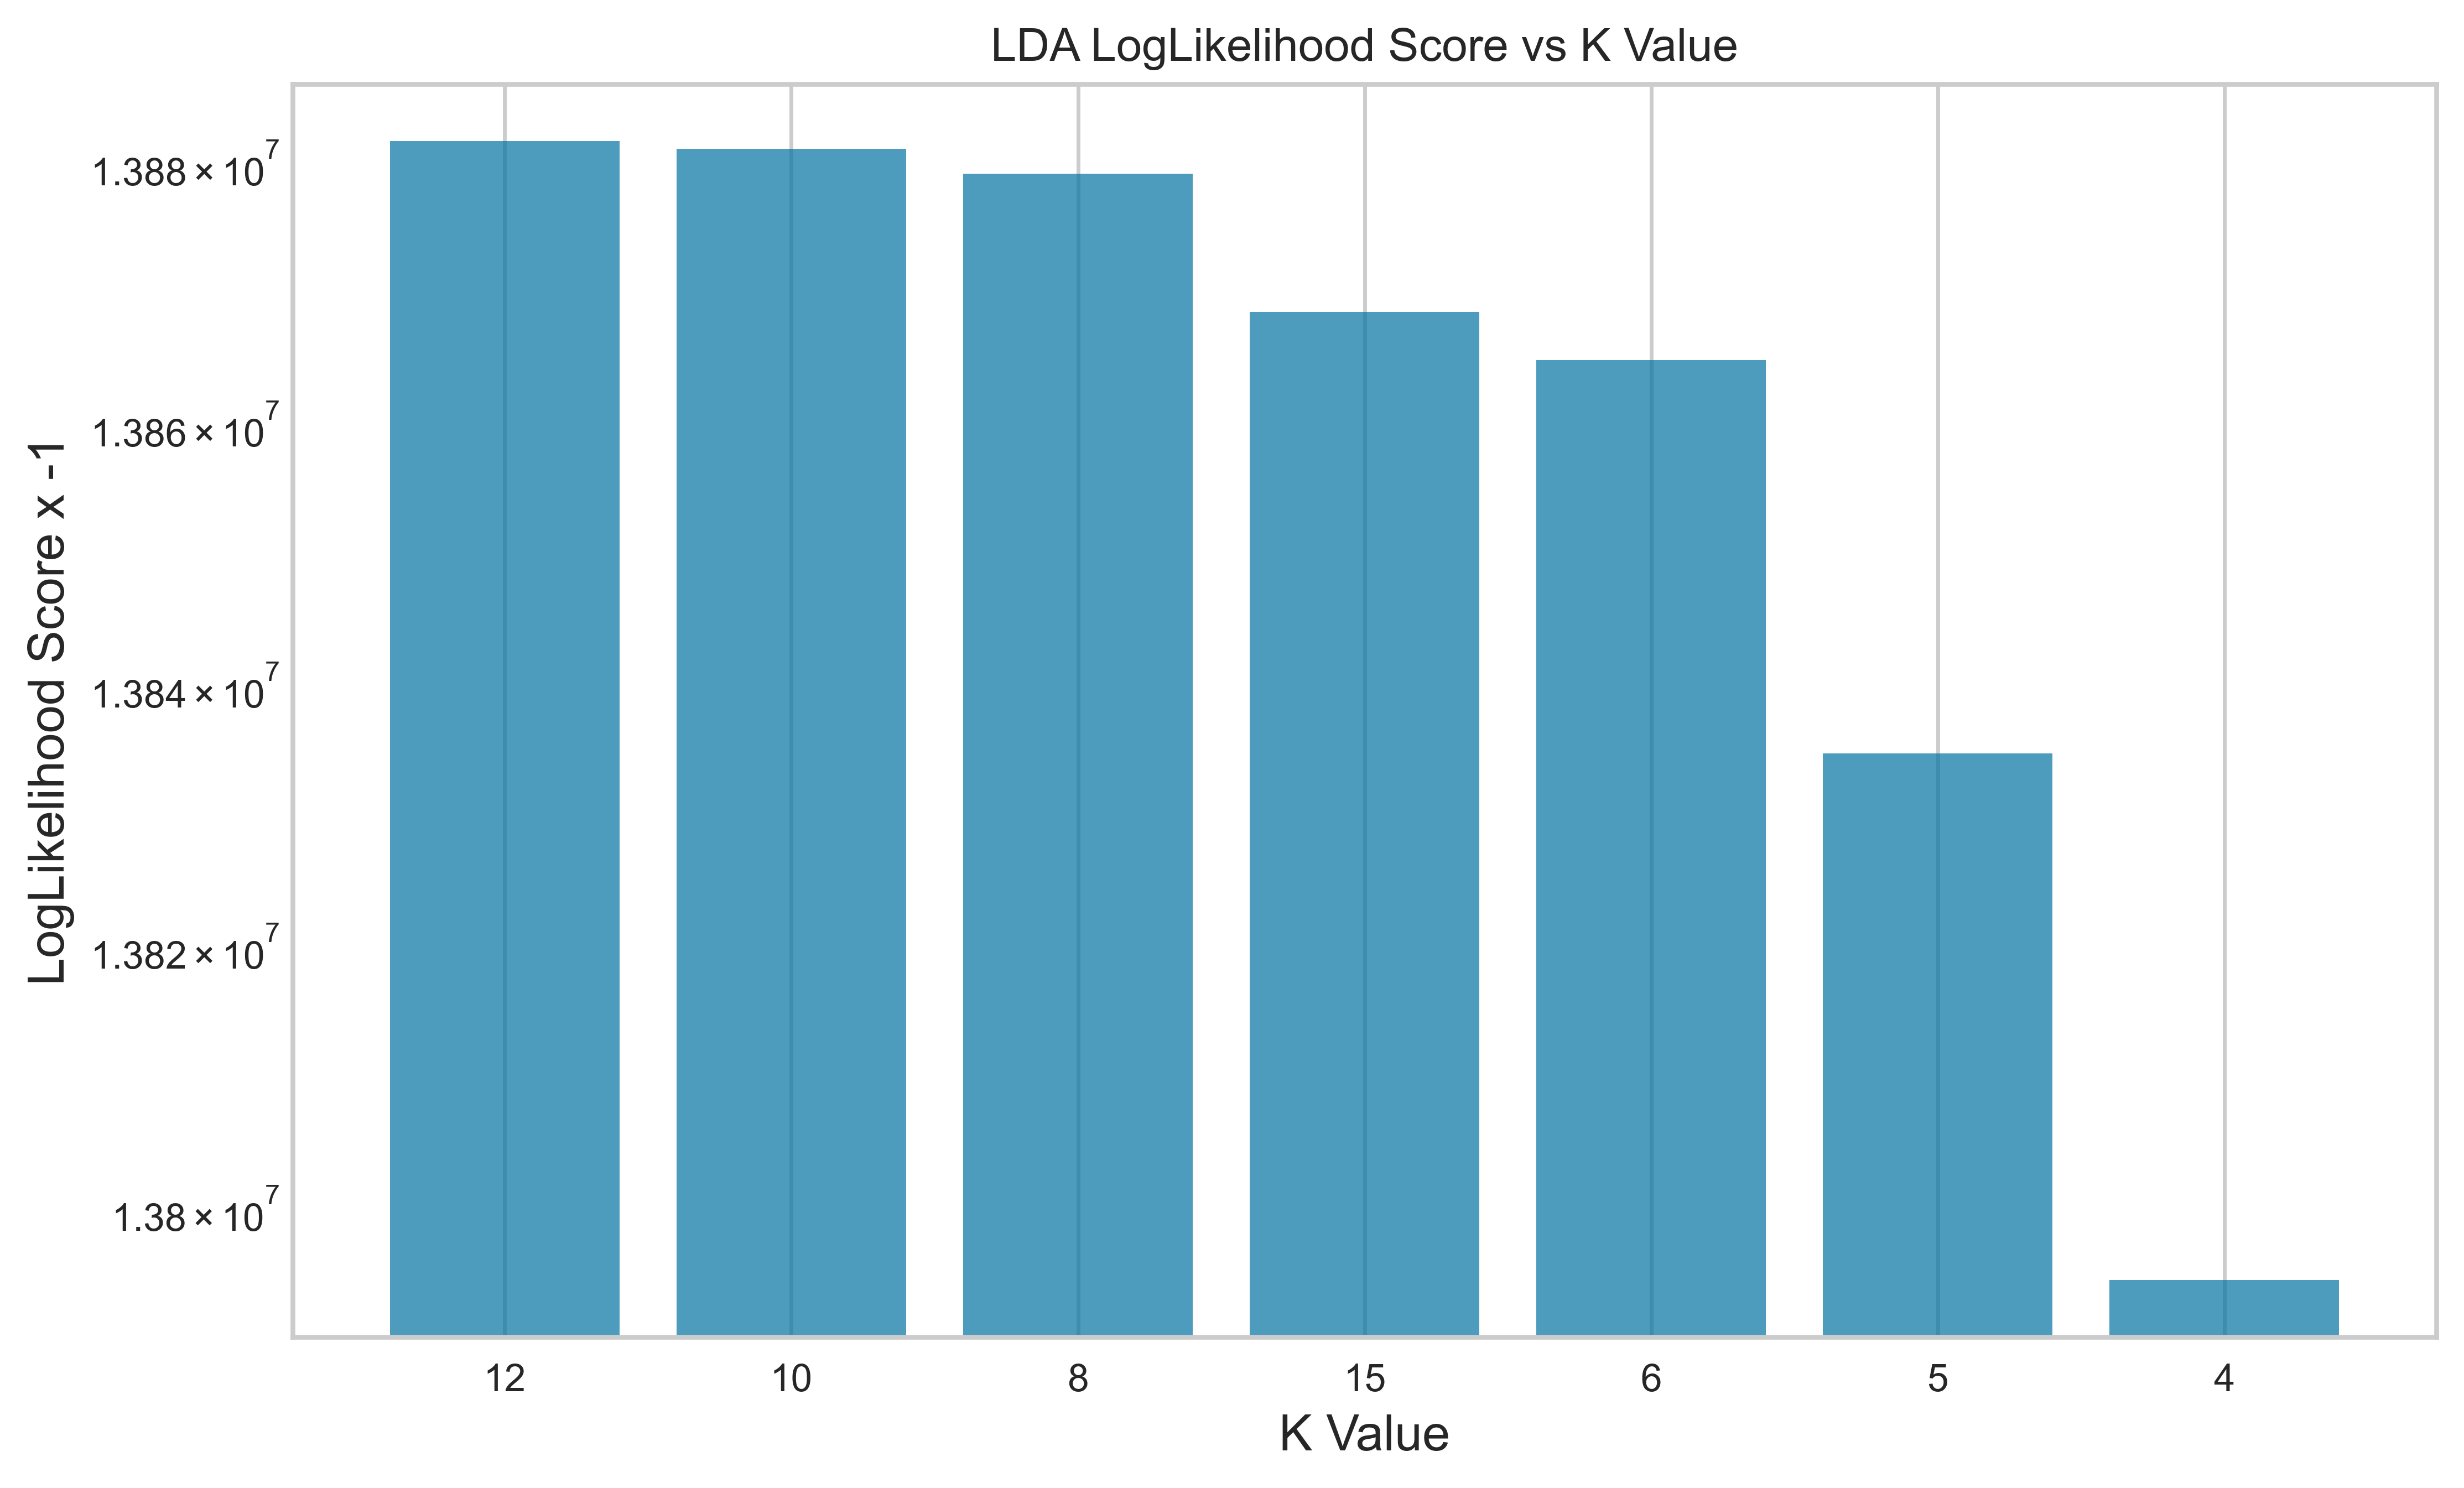

In [20]:
fig, ax = plt.subplots(figsize=(10,6), dpi=500)

y = pd.Series({'6':13865039.19,
                '8':13879343.457206184,
                '10':13881247.966845043,
                '12':13881881.754632398,
                '15':13868745.58349507,
                '5':13834934.496505208,
                '4':13794715.81973467}).sort_values(ascending=False)


ax.bar(y.keys(), y, alpha=0.7)

ax.set_title('LDA LogLikelihood Score vs K Value')

ax.set_xlabel('K Value', fontsize=13)
ax.set_ylabel('LogLikelihood Score x -1', fontsize=13)


ax.set_yscale('log')
# plt.savefig('../images/lda_score.png')
# plt.show();


In [21]:
# lda = LatentDirichletAllocation(n_components=4, learning_method='online',random_state=0)
# lda.fit(X2)
# lda.perplexity(X2)

In [22]:
# lda2 = LatentDirichletAllocation(n_components=5, learning_method='online',random_state=0)
# lda2.fit(X2)
# lda2.perplexity(X2)

In [23]:
# lda3 = LatentDirichletAllocation(n_components=6, learning_method='online',random_state=0)
# lda3.fit(X2)
# lda3.perplexity(X2)

In [24]:
# lda4 = LatentDirichletAllocation(n_components=8, learning_method='online',random_state=0)
# lda4.fit(X2)
# lda4.perplexity(X2)

In [25]:
# lda5 = LatentDirichletAllocation(n_components=10, learning_method='online',random_state=0)
# lda5.fit(X2)
# lda5.perplexity(X2)

In [26]:
# lda6 = LatentDirichletAllocation(n_components=12, learning_method='online',random_state=0)
# lda6.fit(X2)
# lda6.perplexity(X2)

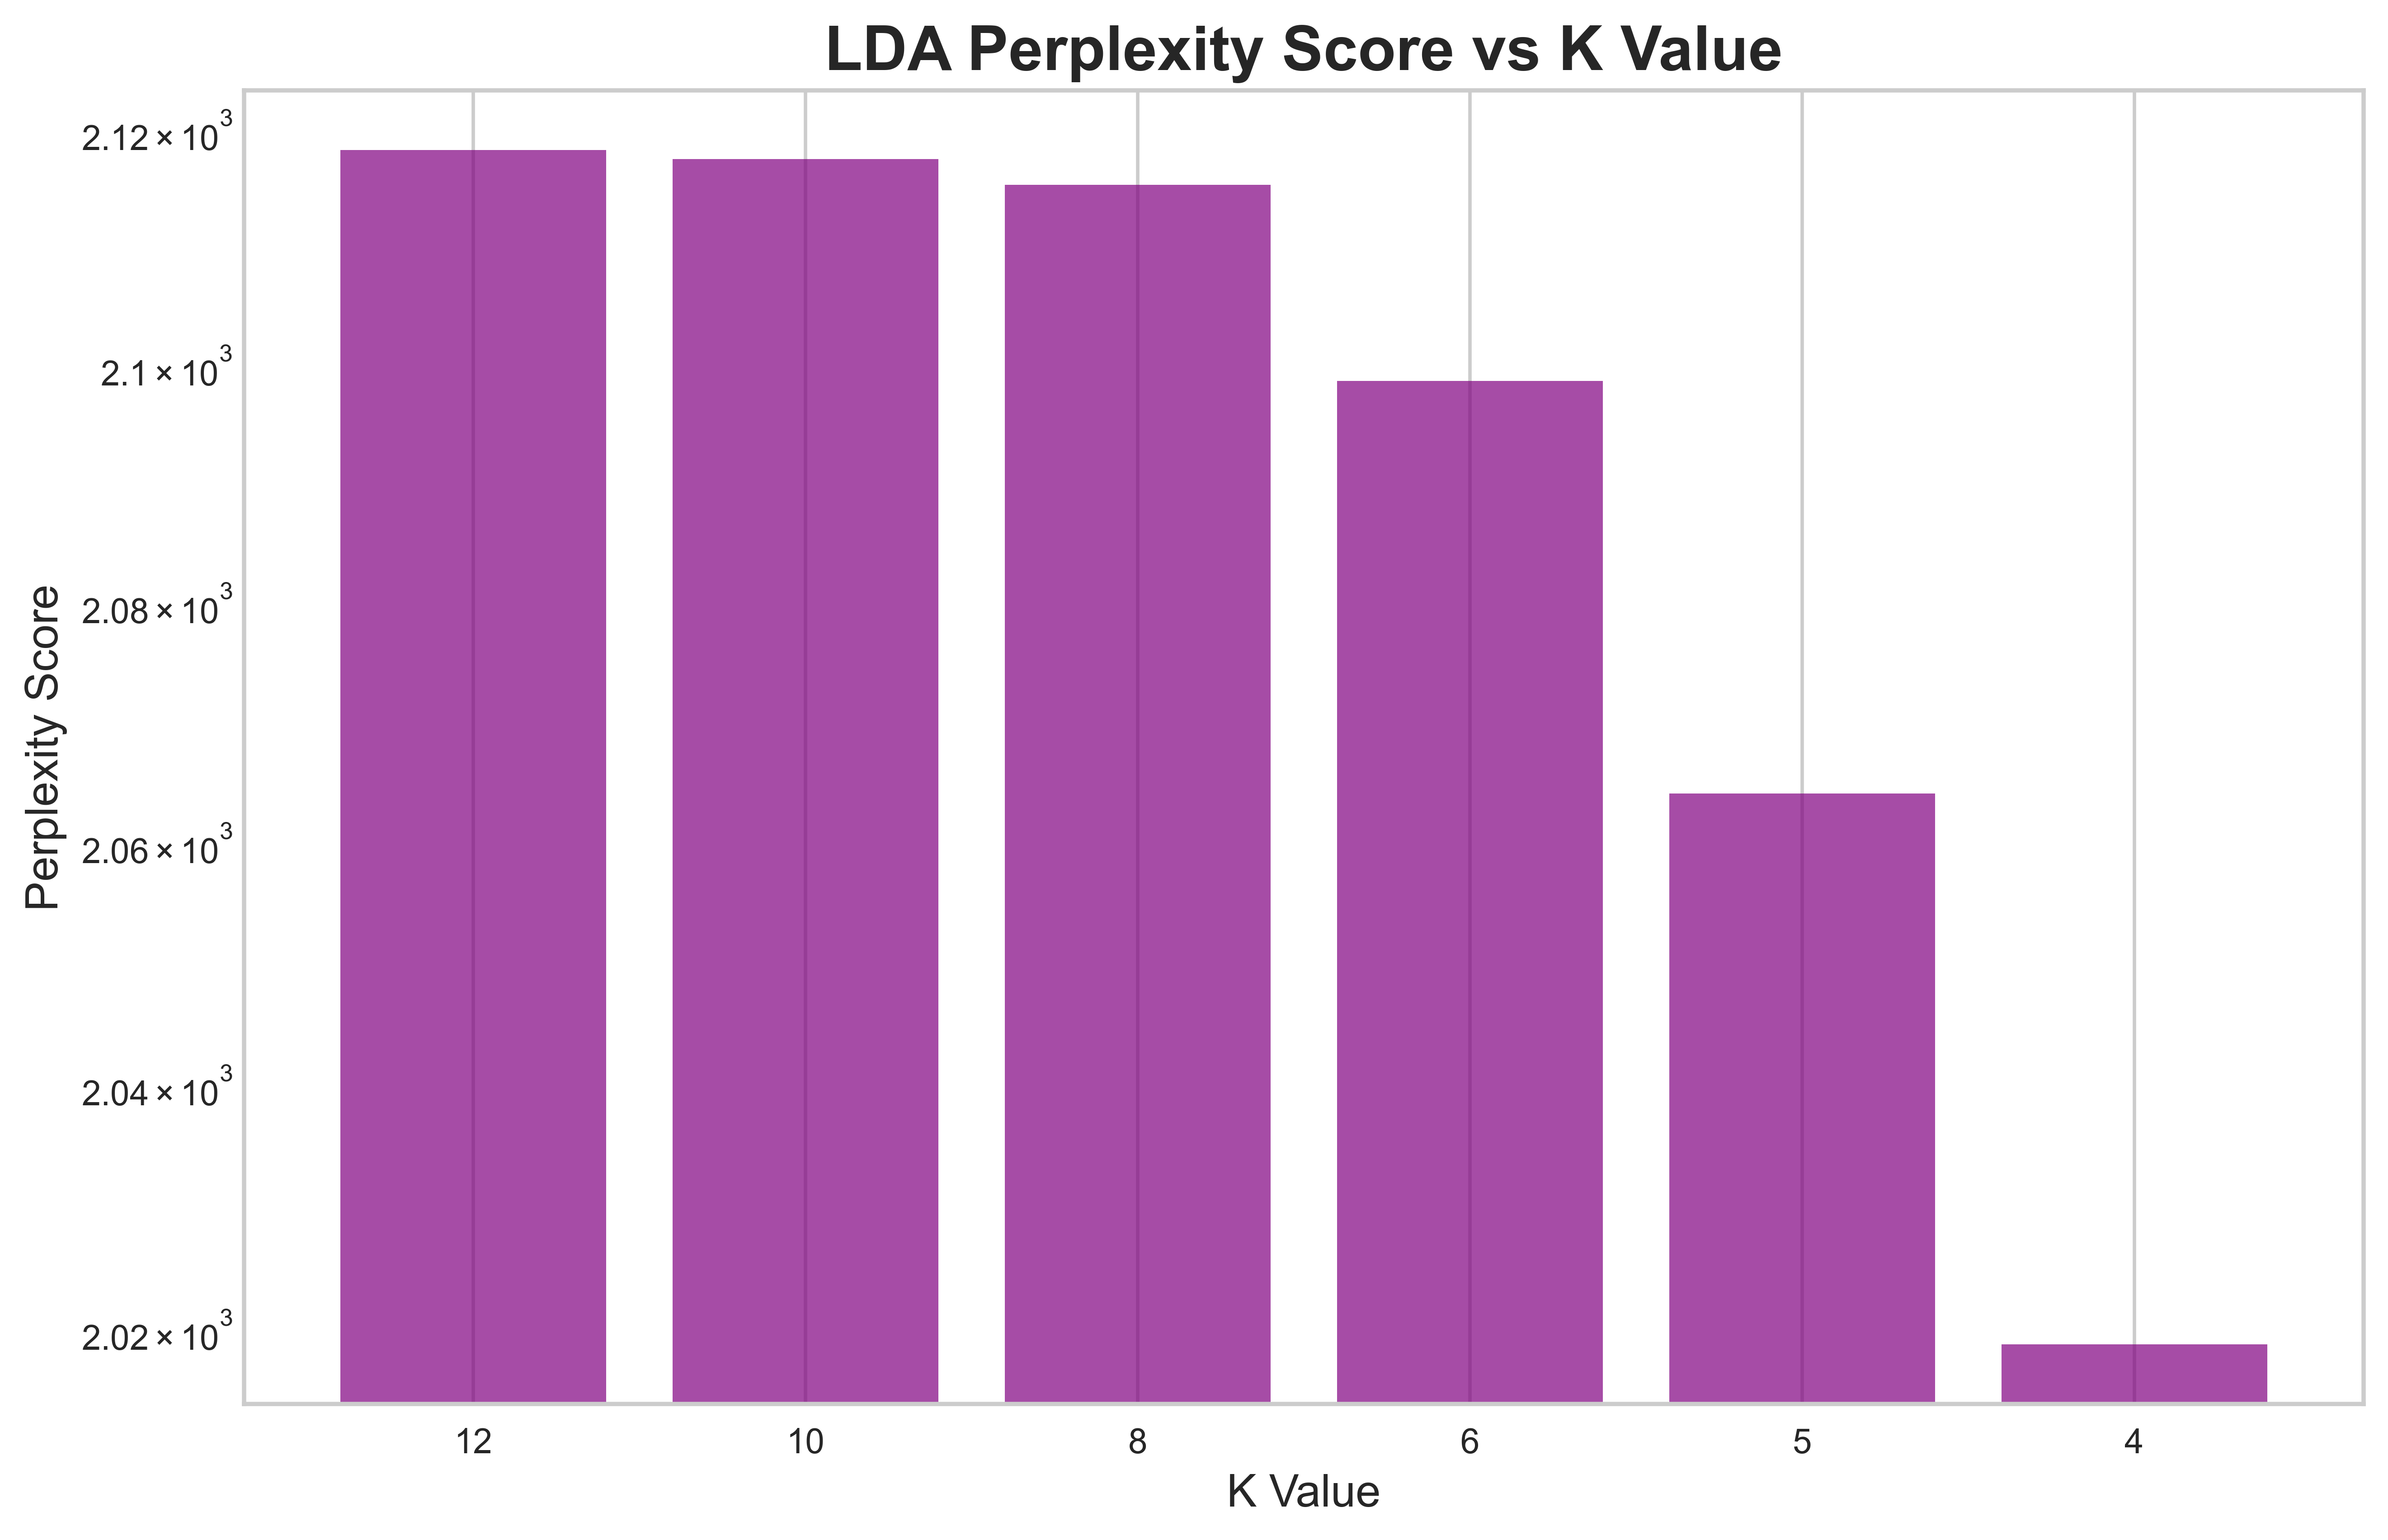

In [27]:
fig, ax = plt.subplots(figsize=(11,7), dpi=550)

y = pd.Series({'4':2018.95,
                '5':2064.25,
                '6':2098.82,
                '8':2115.45,
                '10':2117.67,
                '12':2118.41}).sort_values(ascending=False)


ax.bar(y.keys(), y, alpha=0.7, color='purple')

ax.set_title('LDA Perplexity Score vs K Value',weight='bold', fontsize=18)

ax.set_xlabel('K Value', fontsize=13)
ax.set_ylabel('Perplexity Score', fontsize=13)


ax.set_yscale('log')

plt.savefig('../images/lda_perplexity.png')
plt.show();


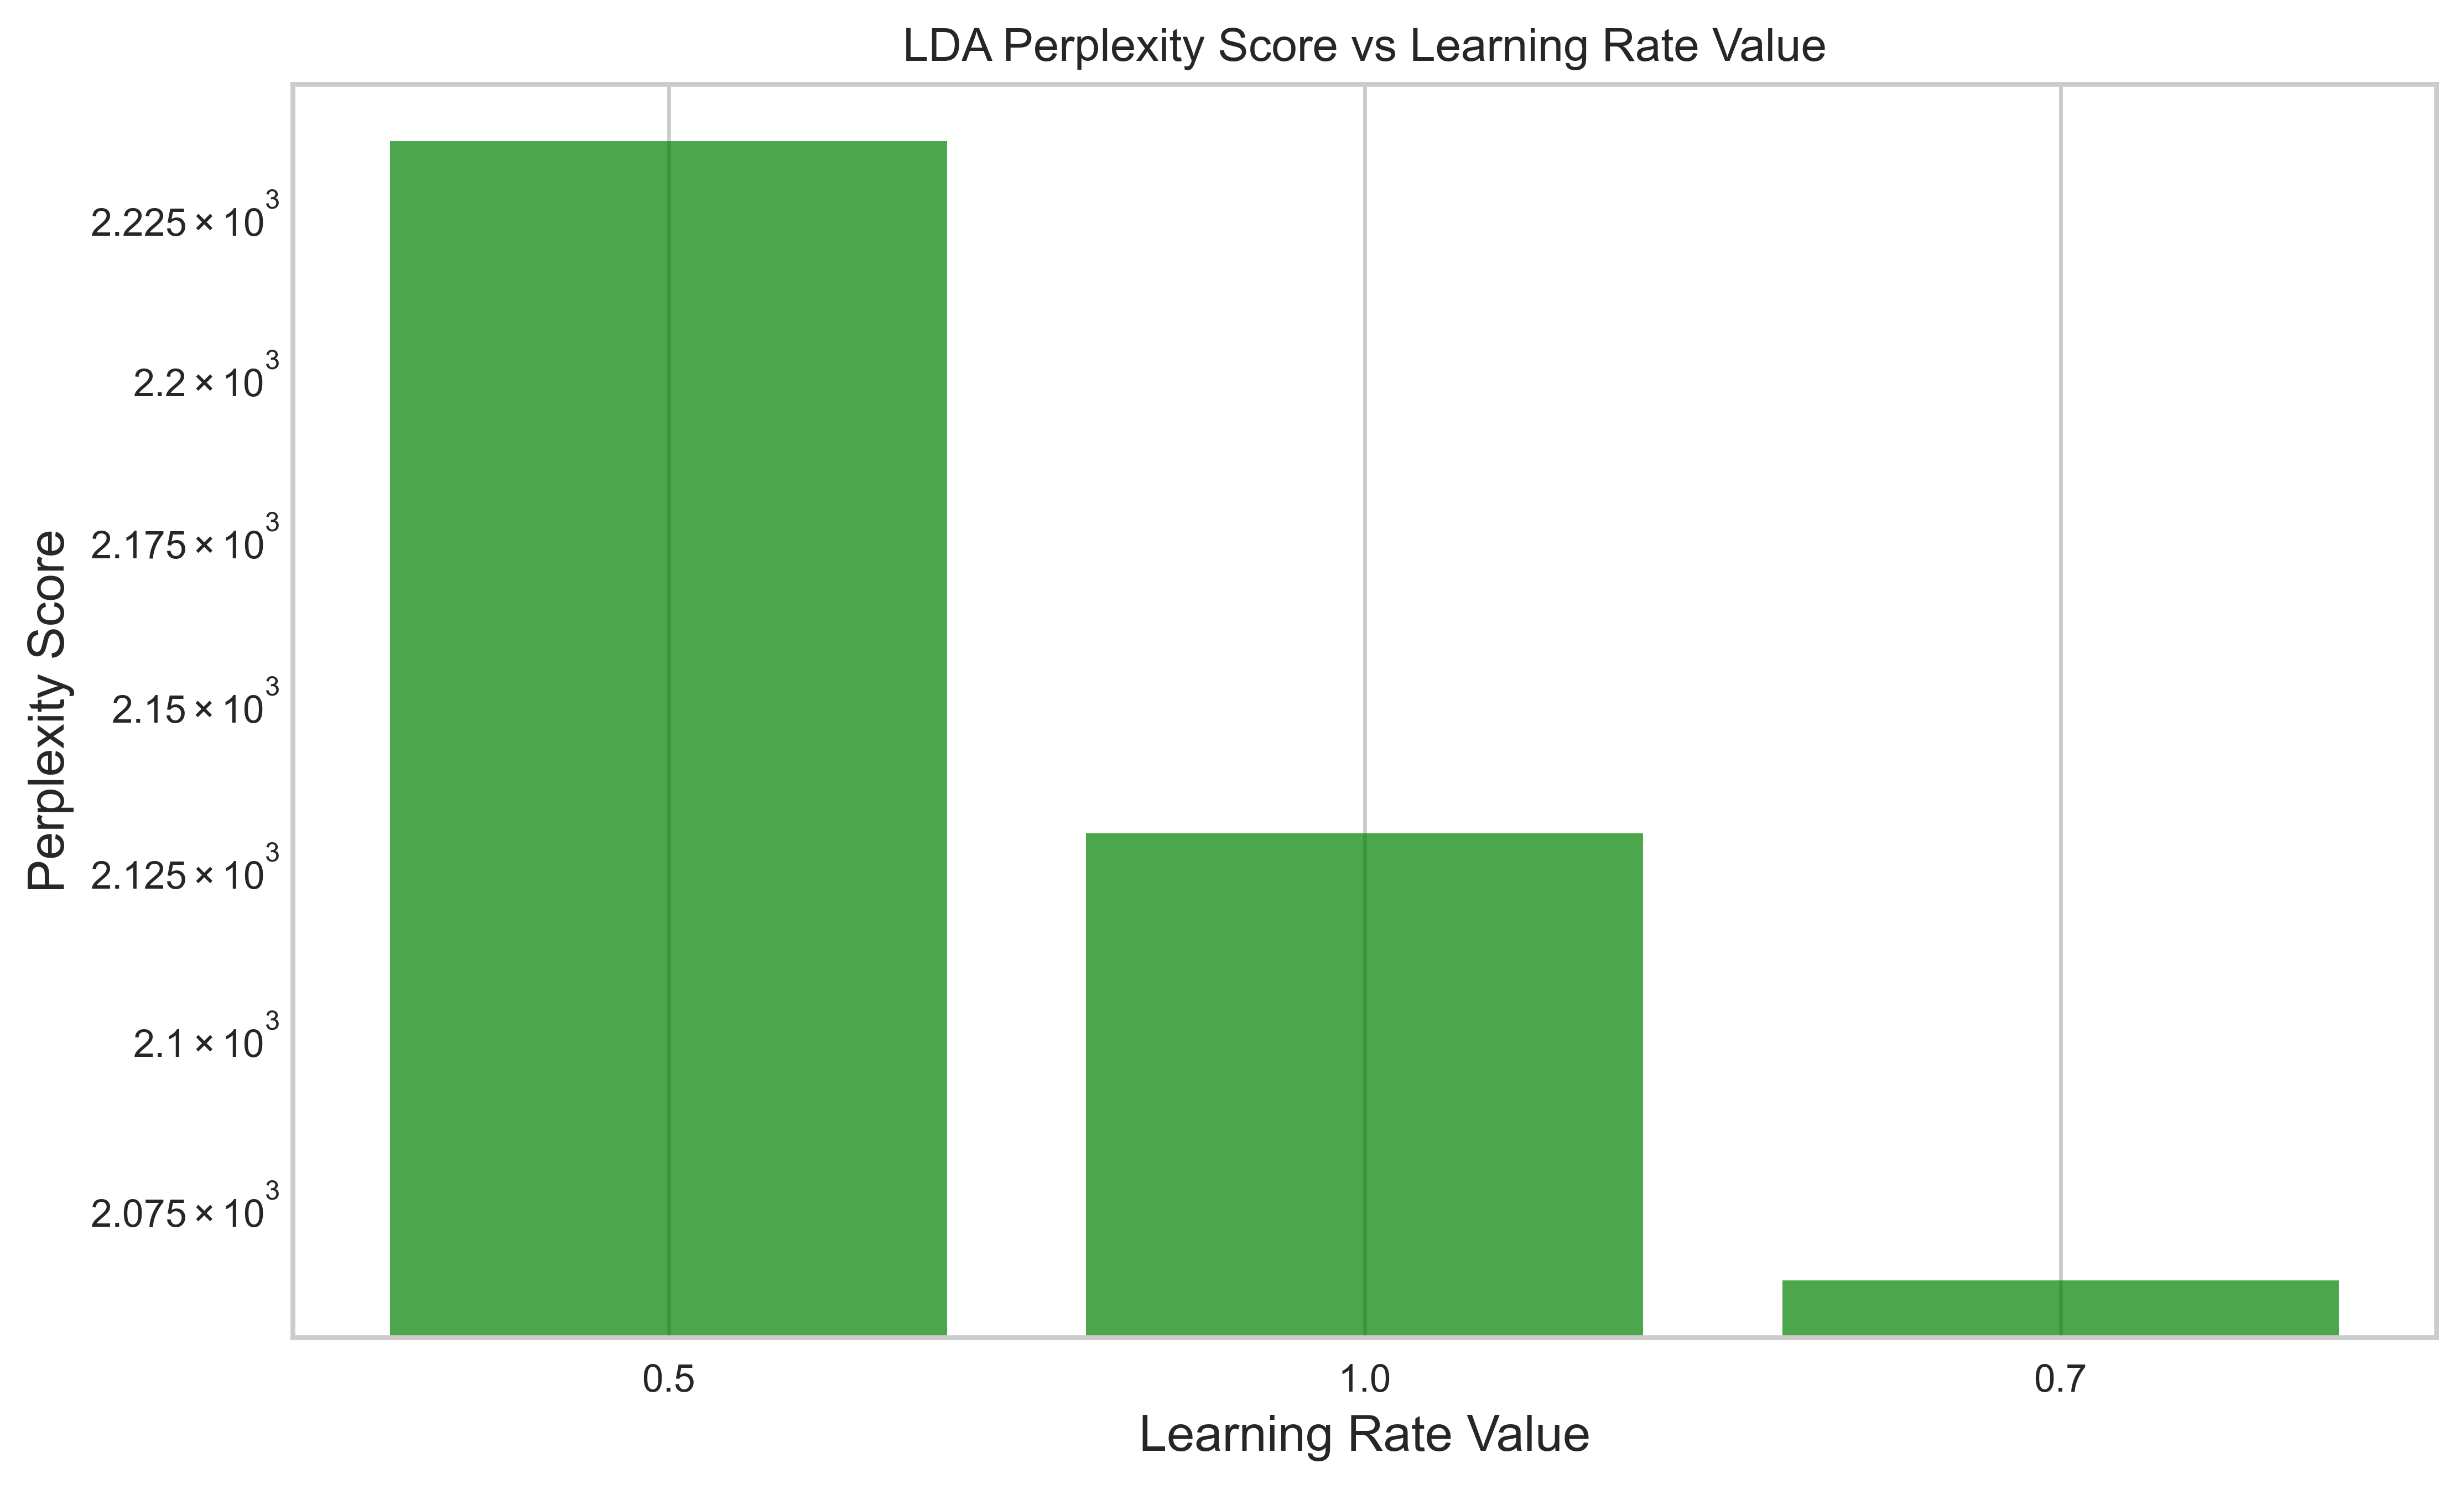

In [28]:
fig, ax = plt.subplots(figsize=(10,6), dpi=500)

y = pd.Series({'0.5':2236.7318894976393,
                '1.0':2130.2805347555213,
                '0.7':2064.253798134296}).sort_values(ascending=False)


ax.bar(y.keys(), y, alpha=0.7, color='green')

ax.set_title('LDA Perplexity Score vs Learning Rate Value')

ax.set_xlabel('Learning Rate Value', fontsize=13)
ax.set_ylabel('Perplexity Score', fontsize=13)


ax.set_yscale('log')

plt.savefig('../images/lda_learningdecay.png')
plt.show();

In [29]:
X2 = vectorizer(ly, count_vec)

In [30]:
lda2 = LatentDirichletAllocation(n_components=5, learning_method='online',random_state=0)
lda2.fit(X2)
lda2.perplexity(X2)

2064.2537981343016

In [31]:
# lda3 = LatentDirichletAllocation(n_components=8, learning_method='online',random_state=0)
# lda3.fit(X2)
# lda3.perplexity(X2)

In [32]:
tf_feature_names = count_vec.get_feature_names()

def display_topics(feature_names, num_top_words, model):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        
display_topics(tf_feature_names, 50, lda2)

Topic 1:
long night home blue tonight play music hear comin bring radio dance sing roll ring swing woah lookin band song guitar songs morning doin christmas tryin little walkin young lord listen train tire tell school waitin wine country thinkin movin lovin runnin days gyal bass record alright rhythm good dancin
Topic 2:
away life heart feel live leave want world break think mind need tell look good change dream eye lose believe walk fall stay things tear inside turn love place long stand hand remember face true night better wanna little start wait girl lonely days wish forget wrong hard today hurt
Topic 3:
fuck money shit bitch wanna want tell gotta better good bout real party think need ready play talk look stop girl smoke game people damn everybody check roll drop kick head drink beat little goin start watch high work feel mouth sick talkin stick hard nothin ball straight shoot hand
Topic 4:
sing hear song sweet fall kiss word cold night sleep miss dream arm summer touch devil sound

In [33]:
lda_topic_matrix = pd.DataFrame(lda2.transform(X2)+1)

In [34]:
lda_topic_matrix.rename({0:'topic_1',1:'topic_2',2:'topic_3',3:'topic_4',4:'topic_5'}, 
                        axis=1, inplace=True)
lda_topic_matrix

,topic_1,topic_2,topic_3,topic_4,topic_5
0,1.002379,1.990544,1.002358,1.002358,1.002361
1,1.004318,1.540920,1.004295,1.053610,1.396858
2,1.008817,1.854465,1.008435,1.119892,1.008391
3,1.360804,1.368038,1.090449,1.176780,1.003929
4,1.004923,1.639502,1.004906,1.004990,1.345679
...,...,...,...,...,...
28367,1.048810,1.037523,1.766518,1.047695,1.099454
28368,1.050452,1.208232,1.457199,1.003541,1.280576
28369,1.002867,1.105549,1.753683,1.002769,1.135133
28370,1.003340,1.003368,1.906971,1.030241,1.056080


In [35]:
pd.set_option('display.max_columns', None)

final_df = pd.concat([ly, lda_topic_matrix], axis=1)

ly['topic'].unique()

array(['sadness', 'world/life', 'music', 'romantic', 'violence',
       'obscene', 'night/time', 'feelings'], dtype=object)

In [36]:
final_df.drop(['len', 'dating','violence','world/life','night/time', 'shake the audience','family/gospel','romantic',
              'communication', 'obscene','music','movement/places','light/visual perceptions','family/spiritual',
               'like/girls', 'topic', 'age'], axis=1, inplace=True)

In [37]:
final_df.loc[final_df['artist_name']=='john mayer'][0:4].values

array([['john mayer', 'back to you', 1999, 'pop',
        'come try forget try stay away late yeah good forget quit game play forgive turn walk away come walk sleep silhouette yeah smile picture leave light leave light yeah know come scare strong',
        0.6556465320463349, 0.04200996615927877, 0.58518358063468,
        0.6353101043509473, 0.0748986695769775, 0.13461538461538464,
        0.5239076669414674, 0.6376263202614536, 1.0074850201929044,
        1.8807003006448322, 1.0075369035288366, 1.0641943923475974,
        1.0400833832858292],
       ['john mayer', 'love soon', 1999, 'pop',
        'know swear read complaint need older warn live take expect kiss time look eye come face come face time cross line want call soon close mind waste time call soon mother complain need mention friends know best keep secret understand wasn plan dollar short minute early come face come face time cross line want call soon close mind waste time call soon bypass bullshit minute hand move faster thi

In [38]:
#User profile sample
user_profile = final_df.loc[final_df['artist_name']=='john mayer']

In [39]:
#Item Profile Sample
item_profile = final_df.drop(final_df[final_df['artist_name'] == 'john mayer'].index).reset_index()
item_profile.drop('index',axis=1, inplace=True)

In [40]:
# Cossine Similarity
from sklearn.metrics.pairwise import cosine_similarity 

user = pd.DataFrame(user_profile.iloc[1, 5:]).T
cosine_similarity(user , item_profile.iloc[:, 5:])[0]

array([0.93727764, 0.97754035, 0.98873362, 0.93822453, 0.9829236 ,
       0.955914  , 0.96807411, 0.98002897, 0.96947116, 0.97762802,
       0.97365989, 0.9487296 , 0.95095315, 0.96775599, 0.95243268,
       0.95881321, 0.90013626, 0.94005402, 0.9473551 , 0.95760145,
       0.98069795, 0.98572242, 0.96609135, 0.97706341, 0.94831438,
       0.9508208 , 0.94757331, 0.93365874, 0.94631852, 0.92265596,
       0.94577265, 0.97467058, 0.96286835, 0.98629908, 0.99164831,
       0.95756791, 0.98408391, 0.97405573, 0.9015999 , 0.93527752,
       0.99005542, 0.88000336, 0.99294259, 0.99419674, 0.98453995,
       0.97524282, 0.98440692, 0.96711003, 0.93520525, 0.9403528 ,
       0.93195255, 0.94307466, 0.95536182, 0.90455586, 0.9820049 ,
       0.97694258, 0.96619619, 0.95388259, 0.98344046, 0.96088253,
       0.90963957, 0.91065219, 0.97529716, 0.96463881, 0.93951925,
       0.96498336, 0.92163468, 0.93035728, 0.95237801, 0.96484829,
       0.97843428, 0.96819636, 0.97942455, 0.94585423, 0.99218

In [41]:
cosine_similarities = cosine_similarity(user , item_profile.iloc[:, 5:])

similar_indices = cosine_similarities[0].argsort()[:-11:-1] 
similar_items = [item_profile.iloc[i] for i in similar_indices] 

recommender=pd.DataFrame(similar_items)

user

,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic_1,topic_2,topic_3,topic_4,topic_5
4679,0.000634115,0.000634115,0.692408,0.651745,0.839357,0.000326923,0.556884,0.356336,1.08622,1.83589,1.04074,1.00295,1.03419


In [94]:
# user_words = input('Words:')
# user_feature_matrix = count_vec.transform(pd.Series(user_words))

# user_topic = lda2.transform(user_feature_matrix)

# user_topic
np.percentile(final_df['sadness'].values, 25)

0.0011441647918423118

In [111]:
def percentiles(col, df=final_df):
    a = np.percentile(df[col].values, [25,50,75]).tolist()
    end =[round(i , 5) for i in a]
    return end

a = percentiles('sadness')
b = percentiles('danceability')
c = percentiles('acousticness')
d = percentiles('instrumentalness')
e = percentiles('valence')
f = percentiles('energy')

In [113]:
def song_recommender(num=5):
    
    user_words = input('Enter words:')
    print('\n''Input Parameters from 0 to 1:')
    print('4 or more decimal points recommended for precision.')
    print('If Parameter is null, enter 0''\n')

    print('For Parameter Definitions go to:')
    print('https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/''\n')

    print(f'Sadness Average: {round(final_df.sadness.values.mean(),3)}')
    print(f'Sadness Percentiles:{a}')
    sadness = float(input('Sadness:'))
          
    print('\n'f'Average Danceability: {round(final_df.danceability.values.mean(),3)}')
    print(f'Danceability Percentiles: {b}')
    danceability = float(input('Danceability:'))
          
    print('\n'f'Average Acousticness: {round(final_df.acousticness.values.mean(),3)}')
    print(f'Acousticness Percentiles: {c}')
    acousticness = float(input('Acousticness:'))
          
          
    print('\n'f'Average Valence: {round(final_df.valence.values.mean(),3)}')  
    print(f'Valence Percentiles: {e}')
    valence = float(input('Valence:'))
          
    print('\n'f'Average Energy: {round(final_df.energy.values.mean(),3)}')
    print(f'Energy Percentiles: {f}')
    energy = float(input('Energy:'))
            
        
    user_feature_matrix = count_vec.transform(pd.Series(user_words))
    user_topic = lda2.transform(user_feature_matrix)
    
    user = [sadness, danceability, acousticness,valence,energy]
    
    user.extend(user_topic[0])
    user = np.array(user).reshape(1,-1)
        
    cosine_similarities = cosine_similarity(user , final_df.loc[:,['sadness',
                                                                   'danceability',
                                                                   'acousticness',
                                                                  'valence',
                                                                  'energy',
                                                                  'topic_1',
                                                                  'topic_2',
                                                                  'topic_3',
                                                                  'topic_4',
                                                                  'topic_5']])

    similar_indices = cosine_similarities[0].argsort()[:-(num+1):-1] 
    similar_items = [final_df.iloc[i] for i in similar_indices] 


    recommender=pd.DataFrame(similar_items)
    return recommender.iloc[:,:5]



song_recommender()

Enter words:jnsdn

Input Parameters from 0 to 1:
4 or more decimal points recommended for precision.
If Parameter is null, enter 0

For Parameter Definitions go to:
https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

Sadness Average: 0.129
Sadness Percentiles:[0.00114, 0.00526, 0.23511]
Sadness:0.1

Average Danceability: 0.533
Danceability Percentiles: [0.41298, 0.53861, 0.65667]
Danceability:0.2

Average Acousticness: 0.339
Acousticness Percentiles: [0.03424, 0.2259, 0.63253]
Acousticness:0.777

Average Valence: 0.533
Valence Percentiles: [0.32914, 0.53937, 0.73825]
Valence:0.042

Average Energy: 0.57
Energy Percentiles: [0.38036, 0.58057, 0.77277]
Energy:0.023


,artist_name,track_name,release_date,genre,lyrics
19417,the ink spots,when the swallows come back to capistrano,1998,jazz,swallow come capistrano promise come whisper f...
15065,bessie smith,devil's gonna git you,1993,blues,long long turn keep burn mister devil pitchfor...
15038,bessie smith,blue spirit blues,1993,blues,dream night dead dream night dead evil spirit ...
17612,bill evans,i'm gettin' sentimental over you,1962,jazz,twist strangle grip feel tendons tear mean twi...
17155,oscar peterson,how high the moon,1952,jazz,damn damn damn damn grow accustom face make be...


In [45]:
def genre_specific(genre, num=5):
    x = song_recommender(num)
    return x.loc[x['genre']==genre]

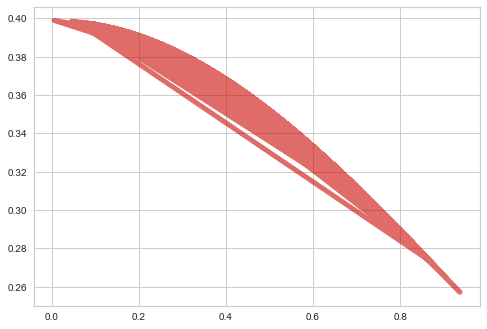

In [46]:
from scipy.stats import norm
fig, ax = plt.subplots(1, 1)
mean, var, skew, kurt = norm.stats(moments='mvsk')

y = ly.loc[ly['genre']=='rock'].danceability.values

x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)

ax.plot(y, norm.pdf(y),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [47]:
y = ly.loc[ly['genre']=='rock'].danceability.values
norm.pdf(y)

array([0.31950182, 0.33573659, 0.32293711, 0.33401978, 0.30215734,
       0.38543881, 0.38220772, 0.32133996, 0.38196452, 0.36501071,
       0.34547833, 0.37016151, 0.35551109, 0.3346655 , 0.35716184,
       0.33206907, 0.34386335, 0.33828074, 0.32225392, 0.32565004,
       0.31765035, 0.28726124, 0.32293711, 0.30555709, 0.32943713,
       0.33141437, 0.34202481, 0.3715428 , 0.37744677, 0.38938761,
       0.36616887, 0.33141437, 0.37703681, 0.35806754, 0.33828074,
       0.38084994, 0.3281082 , 0.38256943, 0.35878617, 0.37620633,
       0.32833028, 0.35697972, 0.31484891, 0.34120044, 0.36922401,
       0.33358804, 0.34825992, 0.33595004, 0.3346655 , 0.37274521,
       0.38256943, 0.34627892, 0.38256943, 0.38159666, 0.39073145,
       0.37363116, 0.33423528, 0.32111093, 0.33828074, 0.37348445,
       0.3715428 , 0.35232243, 0.32293711, 0.36890857, 0.37123845,
       0.37363116, 0.31508345, 0.32632321, 0.37606655, 0.37891951,
       0.37000618, 0.36281422, 0.3610849 , 0.34386335, 0.33743

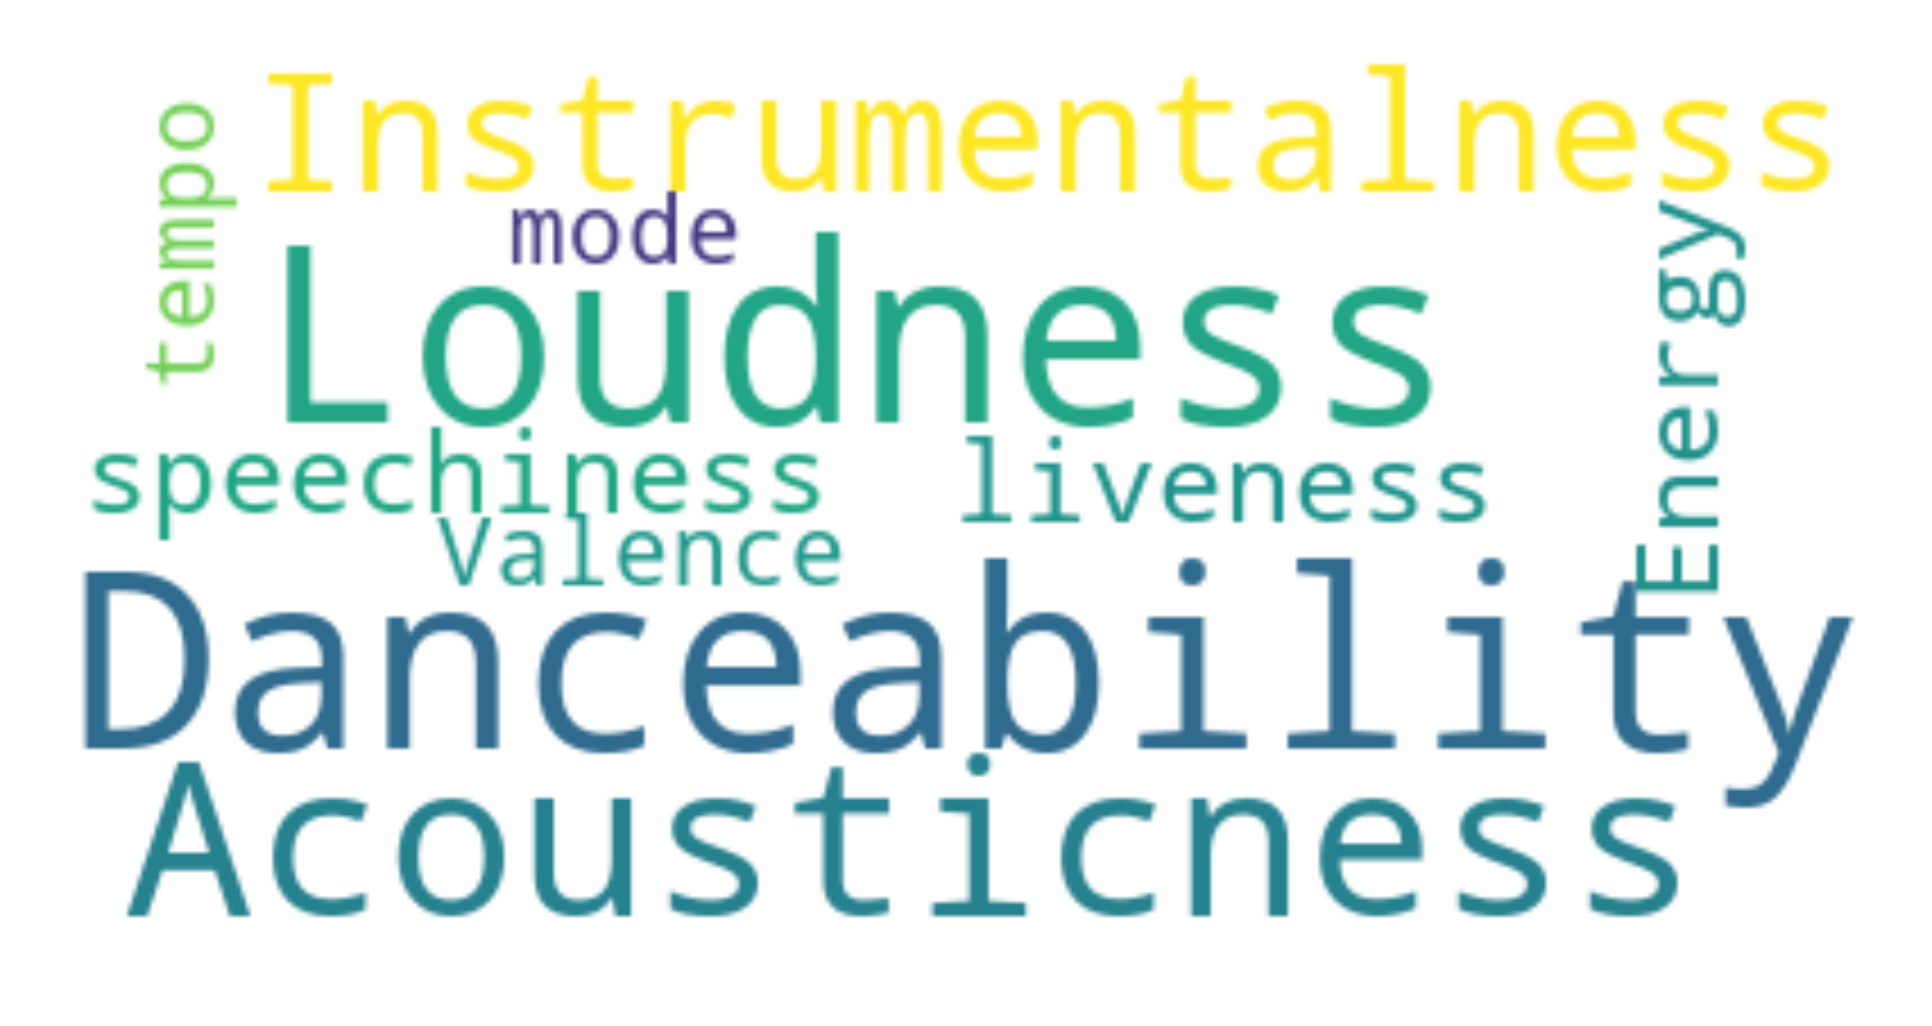

In [48]:
from wordcloud import WordCloud

wc = WordCloud(
    background_color='white',
    max_words=2000)

word_cloud = ['Danceability', 'Loudness', "Acousticness","Instrumentalness","speechiness","Energy",
             'liveness','Valence','tempo','mode']
string = ""
word_cloud_country = (' ').join(word_cloud)
wc.generate(word_cloud_country)

fig, ax1 = plt.subplots(1, 1, figsize=(4,2), dpi=600)

ax1.imshow(wc, interpolation='bilinear')

ax1.axis('off')
plt.savefig('../images/acousticfeatures.png')
plt.show();


In [53]:
wc2 = WordCloud(
    background_color='white',
    max_words=2000)

for topic_idx, topic in enumerate(lda2.components_):
        word_cloud2 = " ".join([feature_names[i]
                        for i in topic.argsort()[:-(10 + 1):-1]])

string = ""
word_cloud_country = (' ').join(word_cloud)
wc.generate(word_cloud_country)

fig, ax1 = plt.subplots(1, 1, figsize=(4,8), dpi=700)

ax1.imshow(wc, interpolation='bilinear')

ax1.axis('off')
plt.savefig('../images/acousticfeatures.png')
plt.show();

for topic_idx, topic in enumerate(lda2.components_):
        print("Topic %d:" % (topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-(10 + 1):-1]]))

NameError: name 'feature_names' is not defined

In [54]:
final_df.loc[ly['track_name']=='waiting on the world to change']

,artist_name,track_name,release_date,genre,lyrics,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic_1,topic_2,topic_3,topic_4,topic_5
5485,john mayer,waiting on the world to change,2006,pop,friends misunderstand stand go wrong world lea...,0.000642,0.04494,0.558107,0.764992,0.159638,0.000235,0.658904,0.756749,1.019641,1.941845,1.002353,1.033805,1.002357


In [56]:
table = song_recommender(20)

Enter words:waiting on the world to change misunderstood friends

Input Parameters from 0 to 1:
4 or more decimal points recommended for precision.
If Parameter is null, enter 0

For Parameter Definitions go to:
https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

Average Sadness: 0.129
Sadness:0.000642

Average Danceability: 0.533
Danceability:0.04494

Average Acousticness: 0.339
Acousticness:0.558107

Average Instrumentalness: 0.08
Instrumentalness:0.764

Average Valence: 0.533
Valence:0.16

Average Energy: 0.57
Energy:0.6


In [69]:
table[0:4]['lyrics'].values

array(['okay heart somebody soon right away right away heart somebody soon right away right away heart somebody soon right away right away',
       'come call better home know pain walk life come call open door grow stronger believe time somebody time hold cause life story toss turn stone pray time heart long come call come call come call better cause hesitate leave sound come call call door call door come call door call door come call door',
       'come little corner world dream little dream little corner world soon forget place tonight share sweet embrace care stay little corner world hide away little corner world know like welcome little corner world care stay little corner world hide away little corner world know like welcome little corner world',
       'darlin care want hold heart hold near whisper hand understand hold heart'],
      dtype=object)